# Estimación de parámetros cosmológicos con emcee

Repetimos el ejercicio de las supernovas para estimar parámetros cosmológicos utilizando el módulo emcee.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from pylab import rcParams
import emcee
import corner

rcParams['figure.figsize'] = (10, 6)

In [2]:
# Extraer datos desde archivos
cov_matrix = np.loadtxt('files/jla_mub_covmatrix.dat')
z = np.loadtxt('files/jla_mub.txt', usecols = 0)
mu = np.loadtxt('files/jla_mub.txt', usecols = 1)
varianza = []

# De cov_matrix solo nos interesa la varianza, que está en la diagonal
for i in range(31):
    varianza.append(cov_matrix[31 * i + i])
    
varianza = np.array(varianza)

In [3]:
def s_func(omega_m):
    return pow((1.0 - omega_m) / omega_m, 1.0 / 3.0)

In [4]:
def eta(a, omega_m):
    s = s_func(omega_m)
    s2 = s**2.0
    s3 = s**3.0
    s4 = s2**2.0
    coef = [-0.154, 0.4304, 0.19097, 0.066941]
    
    return 2.0 * np.sqrt(s3 + 1.0) * pow(1.0/a**4.0 + coef[0]*s/a**3.0 + coef[1]*s2/a**2.0 + \
           coef[2]*s3/a + coef[3]*s4, -1.0/8.0)

In [5]:
def D_L(z, params):
    H_0, omega_m = params
    c = 3.0e5 # km/s
    a0 = 1.0
    a1 = 1.0 / (1.0 + z)
    
    return c * (1.0 + z) * (eta(a0, omega_m) - eta(a1, omega_m)) / H_0

In [6]:
def dist_mu(z, params):
    H_0 = params[0]
    
    return 25.0 - 5.0 * np.log10(H_0 / 100.0) + 5.0 * np.log10(D_L(z, params))

In [7]:
def lnlike(params, mu_arr, z_arr, var_arr): # ln(L)
    suma = np.sum(((mu_arr - dist_mu(z_arr, params)) / var_arr)**2.0)
    return -0.5 * suma

In [8]:
# Esta función es el logaritmo del prior
def lnprior(params):
    H_0, omega = params
    if 50.0 < H_0 < 100.0 and 0.0 <= omega < 1.0:
        return 0.0
    return -np.inf

In [9]:
# Esta función combina el logaritmo del prior con
# la definición de lnlike de arriba para formar
# la función completa log-probability
def lnprob(params, z, mu, varianza):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, z, mu, varianza)

### Estimación por maximización del likelihood

In [10]:
h0_true = 73.0 # Por poner algo
omega_true = 0.3

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [h0_true, omega_true], args = (z, mu, varianza))
h0_ml, omega_ml = result["x"]

/home/quaque/miniconda3/envs/paraemcee/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/quaque/.local/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Ahora ya podemos muestrear nuestra distribución usando emcee. Comenzaremos inicializando los caminadores en una pequeña bola gaussiana alrededor del resultado que ya encontramos para el máximo likelihood:

In [11]:
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

Preparamos el muestreador:

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z, mu, varianza))

Y corremos MCMC con $500$ pasos.

In [13]:
N_steps = 500
sampler.run_mcmc(pos, N_steps);

/home/quaque/miniconda3/envs/paraemcee/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/quaque/miniconda3/envs/paraemcee/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Las siguientes gráficas (_cola de gato_) muestran los valores de cada caminador en cada paso para cada parámetro. Las líneas grises señalan el valor real de los parámetros.

/home/quaque/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


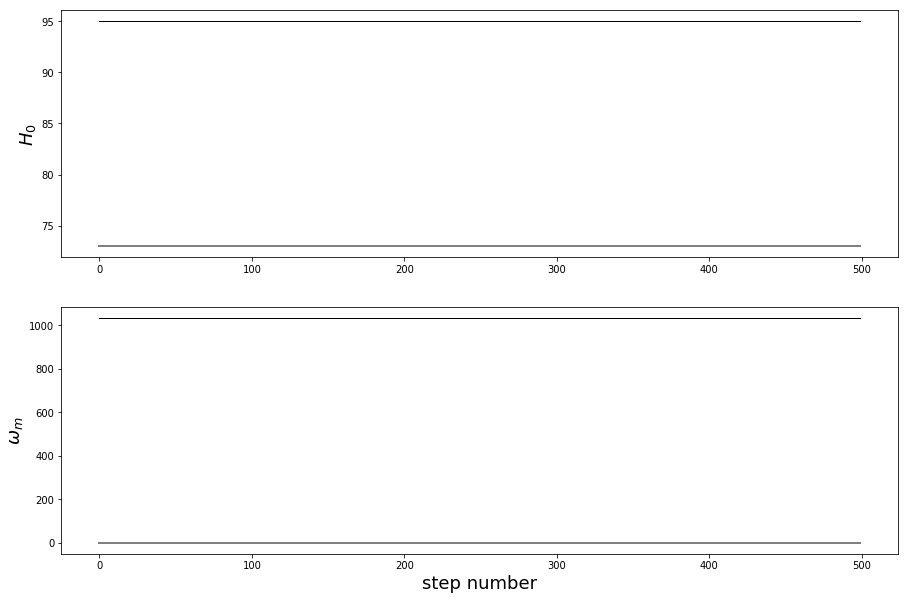

In [15]:
pasos = np.arange(N_steps)
h0_line = h0_true * np.ones(500)
omega_line = omega_true * np.ones(500)
plt.figure(figsize = (15,10))

for i in range(nwalkers):
    plt.subplot(2, 1, 1)
    plt.plot(pasos, sampler.chain[i,:,0], color = 'black', linewidth = 0.5)
    plt.plot(h0_line, color = 'gray')
    plt.ylabel('$H_0$', fontsize = 18)

    plt.subplot(2, 1, 2)
    plt.plot(pasos, sampler.chain[i,:,1], color = 'black', linewidth = 0.5)
    plt.plot(omega_line, color = 'gray')
    plt.ylabel('$\omega_m$', fontsize = 18)
    plt.xlabel('step number',fontsize = 18)

Ignoremos los primeros cincuenta pasos de la muestra:

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Resultados

Es fácil visualizar los resultados utilizando la llamada _gráfica de esquina_ (o de aguacates). Esta gráfica muestra las distribuciones marginalizadas de cada parámetro de manera independiente en los histogramas a lo largo de la diagonal, y las distribuciones marginalizadas dos-dimensionales en el resto de los paneles.

In [ ]:
fig = corner.corner(samples, labels=["$H_0$", "$\omega_m$"],
                      truths=[h0_true, omega_true])